In [1]:
import os, sys

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

from sklearn.utils.extmath import row_norms
from sklearn.metrics.pairwise import _euclidean_distances


project_dir = os.path.abspath("..")
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

from yace.run_worker import JobInfo

In [2]:
def get_performance_results(working_dir):
    distortions_rand = pd.read_feather(working_dir/"distortions-random-solutions.feather")
    distortions_conv = pd.read_feather(working_dir/"distortions-convex-solutions.feather")
    
    df1 = distortions_rand.agg(
        rand_distortion_mean=("distortion", np.mean),
        rand_distortion_std=("distortion", np.std),
        rand_distortion_min=("distortion", np.min),
        rand_distortion_max=("distortion", np.max),
    )

    df2 = distortions_conv.agg(
        conv_distortion_mean=("distortion", np.mean),
        conv_distortion_std=("distortion", np.std),
        conv_distortion_min=("distortion", np.min),
        conv_distortion_max=("distortion", np.max),
    )

    performance_results = pd.concat([df1, df2]).T.to_dict(orient="records")[0]
    return performance_results

def get_results(file_paths):
    raw_data = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        if len(list(working_dir.glob("*.*"))) == 0:
            continue
        perf_results = get_performance_results(working_dir=working_dir)
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        raw_data.append({
            "k": job_info.experiment_params["k"],
            "epsilon": job_info.experiment_params["epsilon"],
            "algorithm": job_info.experiment_params["algorithm_name"],
            "running_time": duration_secs,
            **perf_results,
        })
    df_data = pd.DataFrame(raw_data)
    return df_data

def get_raw_results(file_paths):
    data_frames = []
    for index, job_info_path in enumerate(file_paths):
        job_info = JobInfo.load_json(job_info_path)
        experiment_type = job_info.command_params["experiment-type"]
        working_dir = job_info_path.parent
        duration_secs = int((job_info.completed_at - job_info.started_at).total_seconds())
        if not (working_dir/"distortions-random-solutions.feather").exists():
            continue
        if not (working_dir/"distortions-convex-solutions.feather").exists():
            continue
        df_perf_data = pd.concat([
            pd.read_feather(working_dir/"distortions-random-solutions.feather"),
            pd.read_feather(working_dir/"distortions-convex-solutions.feather")
        ])
        df_perf_data["experiment_id"] = working_dir.name
        df_perf_data["experiment_type"] = experiment_type
        df_perf_data["k"] = job_info.experiment_params["k"]
        df_perf_data["epsilon"] = job_info.experiment_params["epsilon"]
        df_perf_data["algorithm"] = job_info.experiment_params["algorithm_name"]
        df_perf_data["n_points"] = job_info.experiment_params["n_points"]
        df_perf_data["coreset_size"] = job_info.experiment_params["coreset_size"]
        df_perf_data["running_time_secs"] = duration_secs
        df_perf_data["job_info_path"] = job_info_path
        data_frames.append(df_perf_data)
    df_data = pd.concat(data_frames)
    return df_data

def add_combined_mean_std(df: pd.DataFrame, attr: str):
    def combiner(row) -> str:
        mean = row[f"{attr}_mean"]
        std =  row[f"{attr}_std"]
        return f"{mean:0.4f} ({std:0.5f})"
    df[f"{attr}_mean_std"] = df.apply(lambda x: combiner(x), axis=1)


In [3]:
job_info_paths = list(Path("../data/experiments-odin/simple/ss_us_01/").glob("**/job-info.json"))
print(f"Number of job files: {len(job_info_paths)}")

Number of job files: 200


In [4]:
df_raw_results = get_raw_results(job_info_paths)
print(f"Number of results: {df_raw_results.shape[0]}")

Number of results: 20000


In [5]:
grouping_cols = ["experiment_id", "k", "algorithm", "epsilon", "solution_type"]
aggregation_spec = dict(
    distortion_mean=("distortion", np.mean),
    distortion_std=("distortion", np.std),
    n_solutions=("distortion", "count")
)
df_grouped = df_raw_results.groupby(grouping_cols).agg(**aggregation_spec).reset_index()
df_grouped

,experiment_id,k,algorithm,epsilon,solution_type,distortion_mean,distortion_std,n_solutions
0,2022-05-16-07-04-15-686114-030202,10,sensitivity-sampling,0.20,convex,1.018874,1.622563e-02,50
1,2022-05-16-07-04-15-686114-030202,10,sensitivity-sampling,0.20,random,1.004039,2.926536e-03,50
2,2022-05-16-07-04-15-687728-051438,10,sensitivity-sampling,0.10,convex,1.004294,3.241109e-03,50
3,2022-05-16-07-04-15-687728-051438,10,sensitivity-sampling,0.10,random,1.000770,4.928912e-04,50
4,2022-05-16-07-04-15-688743-001868,10,sensitivity-sampling,0.05,convex,1.001082,6.359034e-04,50
...,...,...,...,...,...,...,...,...
395,2022-05-16-07-04-15-776874-029917,100,uniform-sampling,0.10,random,1.000039,2.360866e-05,50
396,2022-05-16-07-04-15-777185-077521,100,uniform-sampling,0.05,convex,1.000207,1.752770e-04,50
397,2022-05-16-07-04-15-777185-077521,100,uniform-sampling,0.05,random,1.000009,5.723241e-06,50
398,2022-05-16-07-04-15-777474-029242,100,uniform-sampling,0.01,convex,1.000008,5.949368e-06,50


In [6]:
colors = sns.color_palette("tab10")
colors = sns.color_palette("bright")
algorithms = np.sort(df_raw_results.algorithm.unique())[::-1]
algorithm_colors = {algo: colors[i] for i, algo in enumerate(algorithms)}
df_raw_results["k_formatted"] = "$k$=" + df_raw_results["k"].astype(str)
df_grouped["k_formatted"] = "$k$=" + df_grouped["k"].astype(str)

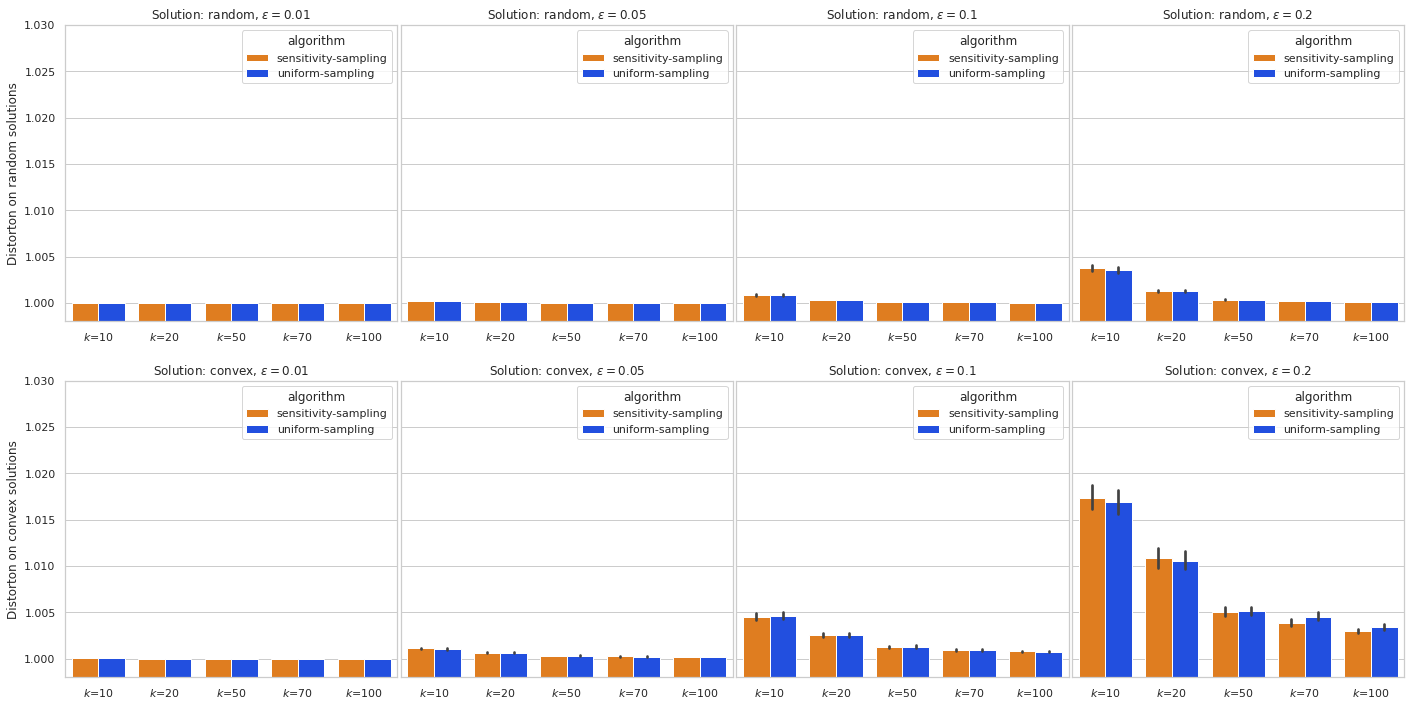

In [7]:
solution_types = df_raw_results["solution_type"].unique()
epsilons = np.sort(df_raw_results["epsilon"].unique())
n_rows = len(solution_types)
n_cols = len(epsilons)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(n_rows*12, n_cols*3))

for i, solution_type in enumerate(solution_types):
    for j, epsilon in enumerate(epsilons):
        ax = axes[i,j]
        f1 = df_raw_results["solution_type"] == solution_type
        f2 = df_raw_results["epsilon"] == epsilon
        df_filtered = df_raw_results[f1&f2].copy()
        df_filtered.sort_values(by=["k", "algorithm"], inplace=True)
        sns.barplot(data=df_filtered, x="k_formatted", y="distortion", hue="algorithm", ax=ax, palette=algorithm_colors)
        ax.set_ylim(bottom=0.998, top=1.03)
        ax.set_title(f"Solution: {solution_type}, $\\epsilon=${epsilon}")
        ax.set_ylabel(f"Distorton on {solution_type} solutions")
        ax.set_xlabel("")
        if j > 0:
            ax.set_ylabel("")            
        if i == 0:
            ax.set_xlabel("")
fig.subplots_adjust(wspace=0.01)
# fig.savefig("distortions-instance-1-v3.pdf", )

## Weight distribution

In [8]:
def get_weights(df_data, epsilon: float=0.2, k: int=10):
    results = dict()
    algorithms = df_data.algorithm.unique()
    for algo in algorithms:
        f1 = df_data["solution_type"] == "convex"
        f2 = df_data["epsilon"] == epsilon
        f3 = df_data["algorithm"] == algo
        f4 = df_data["k"] == k
        
        df_filtered = df_data[f1&f2&f3&f4].copy()
        
        job_info_path = df_filtered.sample(1)["job_info_path"].iloc[0]
        weights = np.load(job_info_path.parent / "coreset-weights.npz")["matrix"]
        results[algo] = weights
    return results

In [9]:
weights_map = get_weights(df_data=df_raw_results, epsilon=0.01, k=10)

# us_coreset_weights, ss_coreset_weights = tuple(list(weights_map.values()))

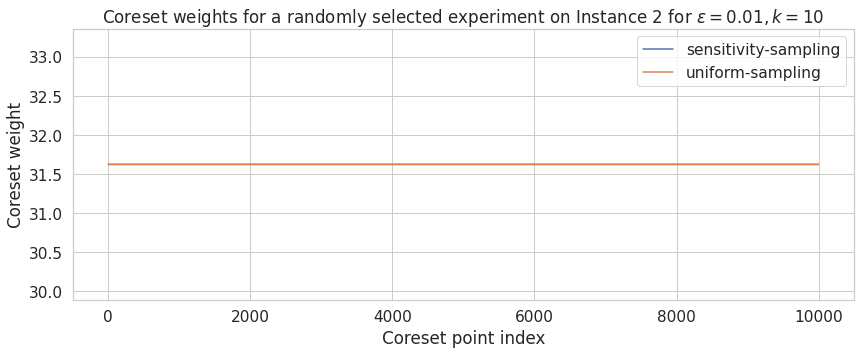

In [10]:
n_weights = list(weights_map.values())[0].shape[0]
a = np.arange(n_weights)

with sns.plotting_context("notebook", font_scale=1.4):
    fig, ax = plt.subplots(figsize=(14, 5))
    for algo, coreset_weights in weights_map.items():
        sns.lineplot(x=a, y=coreset_weights, label=algo, ax=ax)
    ax.set_ylabel("Coreset weight")
    ax.set_xlabel("Coreset point index")
    # ax.set_yscale("log")
    ax.set_title("Coreset weights for a randomly selected experiment on Instance 2 for $\\epsilon=0.01, k=10$")